### Sequence humanization

This notebook evaluates how well the default humanization routine (```suggest_mutations```) in AntPack
works compared with the Sapiens and Hu-mAb alternatives from the literature. Humanization is a tradeoff
between making the sequence as human as possible and preserving as much of the original sequence as
possible (the more changes, the more likely loss of affinity). Most humanization efforts leave the CDRs
unchanged; some also opt to preserve so-called Vernier zones, framework regions thought to be involved
in CDR loop region structure.

In this experiment, we show how setting the s_thresh parameter in AntPack to different values can achieve
either higher humanness or higher preservation depending on priorities. It's also possible to do "manual" humanization
using AntPack -- see the AntPack docs for a tutorial; this experiment considers the automated procedure only.

In [1]:
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from antpack import SingleChainAnnotator, SequenceScoringTool

aligner = SingleChainAnnotator(chains=["H", "K", "L"], scheme = "imgt")

if "notebooks" in os.getcwd():
    current_dir = os.path.join(os.getcwd(), "..", "..")

score_tool = SequenceScoringTool()

os.chdir(current_dir)
    
if "humanization_test_data" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "humanization_test_data"))

In [2]:
paired_seq_dict = {}

target_files = ["parental", "experimental", "sapiens1", "sapiens2", "sapiens3", "sapiens4", "sapiens5",
               "straight_grafts", "vernier_grafts", "humab"]

for seqtype in target_files:
    with open(f"{seqtype}.fa", "r") as fh:
        for seqrec in SeqIO.parse(fh, "fasta"):
            seqname = seqrec.description.split()[0]
            chain = seqrec.description.split()[1]
            if seqname not in paired_seq_dict:
                paired_seq_dict[seqname] = {}
                for key in target_files:
                    paired_seq_dict[seqname][f"{key}_VH"] = None
                    paired_seq_dict[seqname][f"{key}_VL"] = None

            key = f"{seqtype}_{chain}"
            if paired_seq_dict[seqname][key] is not None:
                raise ValueError(f"Duplication on {key}")
            paired_seq_dict[seqname][key] = str(seqrec.seq)

After loading the humanization results for other tools, we'll humanize all 25 sequences in this
dataset using AntPack and store preservation, overlap and humanness scores.

In [3]:
score_progress_dict = {"Name":[],
                      "final_heavy_sequence":[], "final_light_sequence":[],
                       "SAM_125_percent_score":[], "SAM_125_percent_preservation":[], "SAM_125_percent_overlap":[],
                      "SAM_straight_graft_score":[], "SAM_straight_graft_preservation":[], "SAM_straight_graft_overlap":[],
                      "SAM_110_percent_score":[], "SAM_110_percent_preservation":[], "SAM_110_percent_overlap":[]}

for key in target_files:
    score_progress_dict[f"{key}_score"] = []

for key in target_files[1:]:
    score_progress_dict[f"{key}_preservation"] = []
    score_progress_dict[f"{key}_overlap"] = []

for name in paired_seq_dict:
    seq_group = paired_seq_dict[name]
    pvh, pvl, evh, evl = seq_group["parental_VH"], seq_group["parental_VL"], seq_group["experimental_VH"], \
        seq_group["experimental_VL"]

    light_exp_mutations = set( [f"{pvl[j]}_{j+1}_{evl[j]}" for j in range(len(pvl)) if pvl[j] != evl[j] ] )
    heavy_exp_mutations = set( [f"{pvh[j]}_{j+1}_{evh[j]}" for j in range(len(pvh)) if pvh[j] != evh[j] ] )

    score_progress_dict["Name"].append(name)

    for seqtype in target_files:
        score = np.mean( [score_tool.score_seq(seq_group[f"{seqtype}_VH"]),
                          score_tool.score_seq(seq_group[f"{seqtype}_VL"])] )
        score_progress_dict[f"{seqtype}_score"].append(score)

    for seqtype in target_files[1:]:
        total_length, overlap, nmutations = 0, 0, 0

        for chain, expert_set in zip(["VH", "VL"], [heavy_exp_mutations, light_exp_mutations]):
            parental = seq_group[f"parental_{chain}"]
            mutations = [f"{parental[j]}_{j+1}_{seq_group[f'{seqtype}_{chain}'][j]}" for
                         j in range(len(parental)) if parental[j] != seq_group[f"{seqtype}_{chain}"][j] ]
            nmutations += len(mutations)
            overlap += len([m for m in mutations if m in expert_set])
            total_length += len(parental)

        score_progress_dict[f"{seqtype}_preservation"].append( (total_length - nmutations) / total_length)
        score_progress_dict[f"{seqtype}_overlap"].append( overlap / nmutations )

    
    exp_score = np.mean( [score_tool.score_seq(seq_group["experimental_VH"]),
                          score_tool.score_seq(seq_group["experimental_VL"])] )

    hscore, hmuts, uvh = score_tool.suggest_mutations(pvh, s_thresh = 1)
    lscore, lmuts, uvl = score_tool.suggest_mutations(pvl, s_thresh = 1)
        
    overlap = len([m for m in hmuts if m in heavy_exp_mutations]) + \
            len([m for m in lmuts if m in light_exp_mutations])

    nmutations = len(hmuts) + len(lmuts)
    score_progress_dict["SAM_straight_graft_preservation"].append( 1 - nmutations / (len(pvh) + len(pvl)) )
    score_progress_dict["SAM_straight_graft_score"].append(np.mean([score_tool.score_seq(uvh),
                                                        score_tool.score_seq(uvl)]))
    score_progress_dict["SAM_straight_graft_overlap"].append( overlap / max(nmutations, 1) )

    for s_thresh in [1.1, 1.25]:
        hscore, hmuts, uvh = score_tool.suggest_mutations(pvh, s_thresh = s_thresh)
        lscore, lmuts, uvl = score_tool.suggest_mutations(pvl, s_thresh = s_thresh)
        
        overlap = len([m for m in hmuts if m in heavy_exp_mutations]) + \
                len([m for m in lmuts if m in light_exp_mutations])

        text_name = str(int(s_thresh * 100))
        nmutations = len(hmuts) + len(lmuts)
        score_progress_dict[f"SAM_{text_name}_percent_preservation"].append( 1 - nmutations / (len(pvh) + len(pvl)) )
        score_progress_dict[f"SAM_{text_name}_percent_score"].append(np.mean([score_tool.score_seq(uvh),
                                                        score_tool.score_seq(uvl)]))

        score_progress_dict[f"SAM_{text_name}_percent_overlap"].append( overlap / max(nmutations, 1) )

    score_progress_dict["final_heavy_sequence"].append(uvh)
    score_progress_dict["final_light_sequence"].append(uvl)
    

    print(f"Name {name} complete.")



score_progress = pd.DataFrame.from_dict(score_progress_dict)

Name AntiCD28 complete.
Name Campath complete.
Name Bevacizumab complete.
Name Herceptin complete.
Name Omalizumab complete.
Name Eculizumab complete.
Name Tocilizumab complete.
Name Pembrolizumab complete.
Name Pertuzumab complete.
Name Ixekizumab complete.
Name Palivizumab complete.
Name Certolizumab complete.
Name Idarucizumab complete.
Name Reslizumab complete.
Name Solanezumab complete.
Name Lorvotuzumab complete.
Name Pinatuzumab complete.
Name Etaracizumab complete.
Name Talacotuzumab complete.
Name Rovalpituzumab complete.
Name Clazakizumab complete.
Name Ligelizumab complete.
Name Crizanlizumab complete.
Name Mogamulizumab complete.
Name Refanezumab complete.


In [4]:
score_columns = [f"{seqtype}_score" for seqtype in target_files[1:]] + ["SAM_125_percent_score",
                      "SAM_straight_graft_score", "SAM_110_percent_score"]
preservation_columns = [f"{seqtype}_preservation" for seqtype in target_files[1:]]+ ["SAM_125_percent_preservation",
                      "SAM_straight_graft_preservation", "SAM_110_percent_preservation"]
overlap_columns = [f"{seqtype}_overlap" for seqtype in target_files[1:]]+ ["SAM_125_percent_overlap",
                      "SAM_straight_graft_overlap", "SAM_110_percent_overlap"]

score_subset = score_progress[score_columns]
preservation_subset = score_progress[preservation_columns]
overlap_subset = score_progress[overlap_columns]

score_list = np.concatenate([score_progress[col].values - score_progress['parental_score'].values for col in score_columns])
score_labels = np.concatenate([np.full(score_progress.shape[0], c) for c in score_columns])

preservation_list = np.concatenate([score_progress[col] for col in preservation_columns])
preservation_labels = np.concatenate([np.full(score_progress.shape[0], c) for c in preservation_columns])

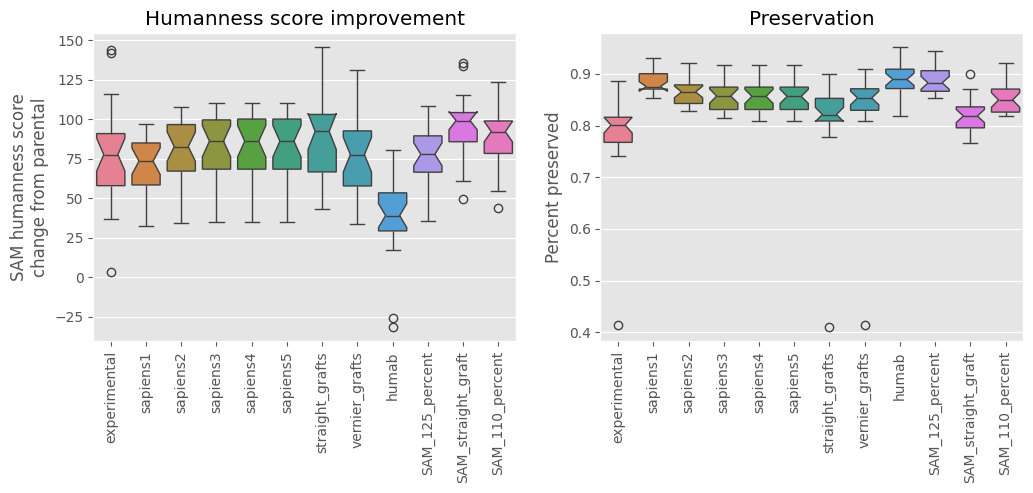

In [5]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

sns.boxplot(x=score_labels, y=score_list, hue=score_labels, notch=True, ax=ax1)
ax1.set_xticks(np.arange(len(score_columns)), [s.split("_score")[0] for s in score_columns], rotation=90)
sns.boxplot(x=preservation_labels, y=preservation_list, hue=preservation_labels, notch=True, ax=ax2)
ax2.set_xticks(np.arange(len(preservation_columns)), [s.split("_preservation")[0] for s in preservation_columns], rotation=90)

ax1.set_title("Humanness score improvement")
ax2.set_title("Preservation")
#plt.suptitle("Humanization algorithm performance", y=1.10)
ax1.set_ylabel("SAM humanness score\nchange from parental")
ax2.set_ylabel("Percent preserved")
plt.show()

In [6]:
import scipy
from scipy import stats

for s in preservation_columns:
    data = score_progress[s].values
    m = data.mean()
    h = stats.sem(data) * scipy.stats.t.ppf(1.95 / 2., data.shape[0] - 1)
    print(f"{s}:\t\t{m}\tLCB:{m-h}\tUCB:{m+h}")

experimental_preservation:		0.7877709023721938	LCB:0.751134128609996	UCB:0.8244076761343917
sapiens1_preservation:		0.8848406070090978	LCB:0.8765425829084643	UCB:0.8931386311097314
sapiens2_preservation:		0.8639708785194375	LCB:0.8535736465414089	UCB:0.8743681104974662
sapiens3_preservation:		0.8572900684457636	LCB:0.8457761549117052	UCB:0.868803981979822
sapiens4_preservation:		0.8558778880154544	LCB:0.8436948941249233	UCB:0.8680608819059855
sapiens5_preservation:		0.8558778880154544	LCB:0.8436948941249233	UCB:0.8680608819059855
straight_grafts_preservation:		0.8122970061019416	LCB:0.7755651354603361	UCB:0.849028876743547
vernier_grafts_preservation:		0.8374280595753594	LCB:0.799467525270013	UCB:0.8753885938807058
humab_preservation:		0.8895543741251224	LCB:0.8758339867126405	UCB:0.9032747615376043
SAM_125_percent_preservation:		0.8872033791532559	LCB:0.8769970912538738	UCB:0.8974096670526379
SAM_straight_graft_preservation:		0.8205116339914201	LCB:0.8075294167279672	UCB:0.83349385125

In [7]:
for s in overlap_columns:
    data = score_progress[s].values
    m = data.mean()
    h = stats.sem(data) * scipy.stats.t.ppf(1.95 / 2., data.shape[0] - 1)
    print(f"{s}:\t\t{m}\tLCB:{m-h}\tUCB:{m+h}")

experimental_overlap:		1.0	LCB:1.0	UCB:1.0
sapiens1_overlap:		0.7616629838760274	LCB:0.6996258462683147	UCB:0.82370012148374
sapiens2_overlap:		0.7275455112379038	LCB:0.6642812581634889	UCB:0.7908097643123186
sapiens3_overlap:		0.7141909963165266	LCB:0.6469597743196788	UCB:0.7814222183133744
sapiens4_overlap:		0.7111781399548665	LCB:0.6427113446010057	UCB:0.7796449353087272
sapiens5_overlap:		0.7111781399548665	LCB:0.6427113446010057	UCB:0.7796449353087272
straight_grafts_overlap:		0.6501413776388795	LCB:0.5798705805946116	UCB:0.7204121746831473
vernier_grafts_overlap:		0.7005321436907466	LCB:0.6338608951194112	UCB:0.7672033922620819
humab_overlap:		0.6995824127955426	LCB:0.6583365904331374	UCB:0.7408282351579477
SAM_125_percent_overlap:		0.744464639271323	LCB:0.6774551978999289	UCB:0.8114740806427171
SAM_straight_graft_overlap:		0.7070384765196737	LCB:0.6416036870260275	UCB:0.7724732660133198
SAM_110_percent_overlap:		0.7278541553580931	LCB:0.6624413120943488	UCB:0.7932669986218374
